In [1]:
import os
import numpy as np
import pandas as pd
import json

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import xgboost as xgb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def load_json(filepath: str):
    with open(filepath) as file:
        data = json.load(file)
    return data

In [3]:
DATA_DIR = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())), "data/"
)

PERIODIC_TABLE_PATH = os.path.join(
    os.path.dirname(os.getcwd()), "data_preprocessing/periodic_table_info.json",
)
PERIODIC_TABLE_INFO = load_json(PERIODIC_TABLE_PATH)

# Loading Data

In [4]:
def parse_structure_names(DATA_PATH=DATA_DIR):
    structure_names = []
    for filename in os.listdir(DATA_PATH):
        ext = ".json"
        if filename.endswith(ext):
            structure_name = filename[: -len(ext)]
            elements_nbrs = {
                elt.split("-")[0]: int(elt.split("-")[1])
                for elt in structure_name.split("_")
            }
            # Skip Lantanides
            isLant = False
            for elt in elements_nbrs.keys():
                ELEMENT_INFO = PERIODIC_TABLE_INFO[elt]
                if ELEMENT_INFO["PTC"] == "Lant":
                    isLant = True
            
            if not isLant:
                structure_names.append(structure_name)
            
    return structure_names

In [5]:
# structure_names = ["Ge-1_Se-1", "Ge-1_Te-1", "Ge-1_Sb-1", "Si-1_C-1"]
structure_names= parse_structure_names()
encoding = "column_mass"

In [6]:
df = pd.concat([pd.read_csv(os.path.join(DATA_DIR, f"{struct_name}_{encoding}.csv"), index_col=0) for struct_name in structure_names], ignore_index=True)

In [7]:
cols_raw = list(df.columns)
cols_trash = ['converged', 'accuracy']
cols_independent = ['delta_E']
cols_drop = cols_trash + cols_independent

cols_dependent = cols_raw.copy()
for element in cols_drop:
    cols_dependent.remove(element)

In [8]:
X_raw = df[cols_dependent]
y_raw = np.abs(df[cols_independent]).squeeze()

In [9]:
X_raw.describe()

,ecutrho,k_density,ecutwfc,PTC1,PTC2,PTC3,PTC4,PTC5,PTC6,PTC7,...,PTC9,PTC10,PTC11,PTC12,PTC13,PTC14,PTC15,PTC16,PTC17,PTC18
count,8054.000000,8054.000000,8054.000000,8054.000000,8054.000000,8054.0,8054.000000,8054.0,8054.000000,8054.000000,...,8054.000000,8054.000000,8054.000000,8054.0,8054.000000,8054.000000,8054.000000,8054.000000,8054.000000,8054.0
mean,244.802583,5.948349,58.157437,0.042358,0.135510,0.0,0.025073,0.0,0.026622,0.038839,...,0.135037,0.041494,0.056502,0.0,0.053620,0.215026,0.117082,0.107854,0.004984,0.0
std,89.329800,2.827780,23.638399,0.156621,0.320536,0.0,0.084135,0.0,0.090310,0.131421,...,0.314731,0.140404,0.189597,0.0,0.214920,0.305004,0.220288,0.211786,0.019978,0.0
min,100.000000,2.000000,20.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,180.000000,4.000000,40.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,260.000000,6.000000,60.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,340.000000,8.000000,75.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.373663,0.000000,0.000000,0.000000,0.0
max,380.000000,10.000000,100.000000,0.621404,1.000000,0.0,0.307361,0.0,0.332943,0.483476,...,1.000000,0.516524,0.692639,0.0,0.914951,1.000000,0.626337,0.637235,0.085049,0.0


# Train-Test-Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    random_state=42
)

# Model definitions

### Linear Model with feature augmentation

In [11]:
# functions such that f(x) != 0 and f(+inf) = 0
functions_set_1 = [
    lambda x: np.exp(-x),
    lambda x: 1 / (1+x),
    lambda x: 1 / (1+x)**2,
    lambda x: np.cos(x) * np.exp(-x),
]

# functions such that f(x) = 0 and f(+inf) = 0
functions_set_2 = [
    lambda x: x*np.exp(-x),
    lambda x: x / (1+x)**2,
    lambda x: x / (1+x)**3,
    lambda x: np.sin(x) * np.exp(-x),
]

linear_augmented_model = Pipeline([
    ('scaler_init', StandardScaler()),
    ('features', FeatureUnion(
    [
        (f"fun_{j}", FunctionTransformer(lambda X : f(X[:,:3]))) for j, f in enumerate(functions_set_1 + functions_set_2)
    ] + [
        (f"fun_{j}_col_{col}_1", FunctionTransformer(lambda X : f(X[:,:3] * X[:,i][:, None]))) for j, f in enumerate(functions_set_1) for i, col in enumerate(["ecutrho", "kpoints", "ecutwfc"])
    ] + [
        (f"fun_{j}_col_{col}_2", FunctionTransformer(lambda X : f(X[:,3:] * X[:,i][:, None]))) for j, f in enumerate(functions_set_2) for i, col in enumerate(["ecutrho", "kpoints", "ecutwfc"])
    ])),
    ('scaler_final', StandardScaler()),
    ('regressor', LinearRegression()),
])

### Random forest

In [12]:
rf_model = RandomForestRegressor(random_state=0)

### Gradient Boosting

In [13]:
gb_model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

### XGBoost

In [14]:
xgb_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

### Packing them together to reduce code size

In [15]:
models = {
    "Augmented Linear Regression": linear_augmented_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "XGBoost": xgb_model,
}

# Model training

In [16]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print("Done!\n")

Training Augmented Linear Regression...
Done!

Training Random Forest...
Done!

Training Gradient Boosting...
Done!

Training XGBoost...
Done!



# Model evaluation

In [17]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Augmented Linear Regression...
MSE:	train:1.1532E-02	test:1.4035E-02
MAPE:	train:1.2157E+11	test:2.4104E+11
Done!

Evaluating Random Forest...
MSE:	train:6.1798E-08	test:4.4483E-07
MAPE:	train:3.3503E+07	test:1.8877E+07
Done!

Evaluating Gradient Boosting...
MSE:	train:9.0846E-07	test:1.7872E-06
MAPE:	train:1.0122E+09	test:7.0685E+08
Done!

Evaluating XGBoost...
MSE:	train:9.4963E-07	test:1.5467E-06
MAPE:	train:1.6157E+09	test:3.7816E+08
Done!



# Visualization

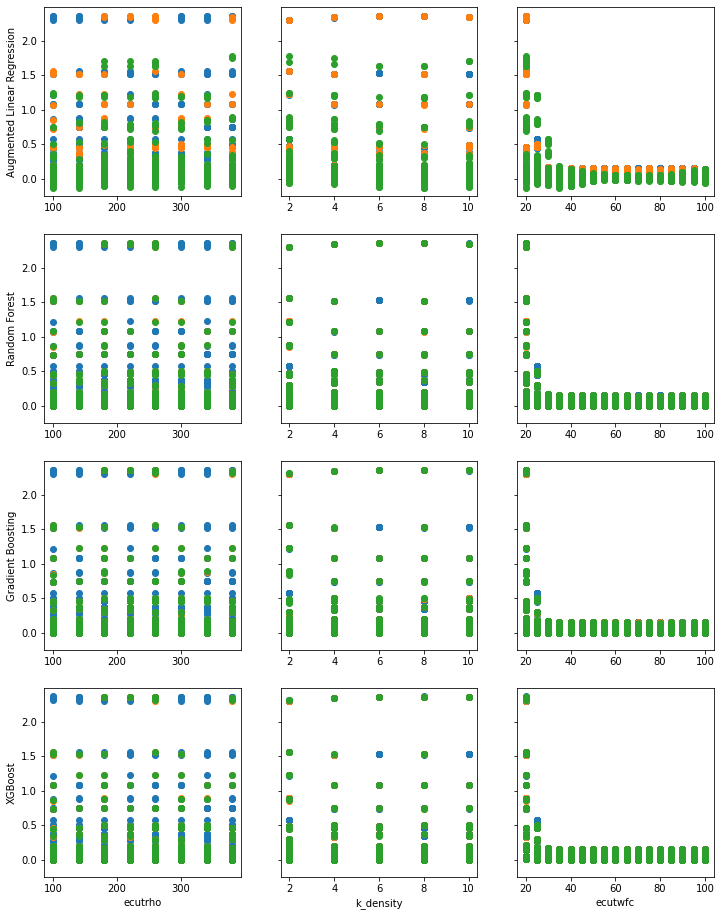

In [18]:
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], y_train)
        ax[j,i].scatter(X_test[col], y_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')
PLOTPATH = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "plots/delta_E_regression/toy_comparison.png")
plt.savefig(PLOTPATH)

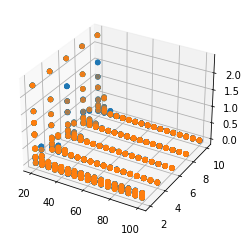

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['ecutwfc'], X_train['k_density'], y_train)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], y_test)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], rf_model.predict(X_test))

## Predict $\log(\Delta E)$ instead of $∆E$

In [20]:
def log_transform(y, miny, eps=10E-15):
    return np.log(y - miny + eps)

def inv_log_transform(logy, miny, eps=10E-15):
    return np.exp(logy) + miny - eps

miny = float(np.min(y_raw))
maxy = float(np.max(y_raw))

y_raw_s = np.array(y_raw.squeeze())
miny2 = np.sort(list(set(list(y_raw_s))))[1]
eps = (miny2 - miny)/10

    

logy_raw = log_transform(y_raw, miny, eps)
X_train, X_test, logy_train, logy_test = train_test_split(
    X_raw, logy_raw,
    test_size=0.2,
    random_state=42
)

In [21]:
linear_log_augmented_model = Pipeline([
    ('scaler_init', StandardScaler()),
    ('features', PolynomialFeatures(degree=2)),
    ('scaler_final', StandardScaler()),
    ('regressor', LinearRegression()),
])

In [22]:
rf_log_model = RandomForestRegressor()

In [23]:
gb_log_model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

In [24]:
xgb_log_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

In [25]:
models = {
    "Augmented Linear Regression - Log": linear_log_augmented_model,
    "Random Forest - Log": rf_log_model,
    "Gradient Boosting - Log": gb_log_model,
    "XGBoost - Log": xgb_log_model,
}

In [26]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, logy_train)
    print("Done!\n")

Training Augmented Linear Regression - Log...
Done!

Training Random Forest - Log...
Done!

Training Gradient Boosting - Log...
Done!

Training XGBoost - Log...
Done!



In [27]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    logy_pred_train = model.predict(X_train)
    y_pred_train = inv_log_transform(logy_pred_train.squeeze(), miny, eps)
    logy_pred_test = model.predict(X_test)
    y_pred_test = inv_log_transform(logy_pred_test.squeeze(), miny, eps)
    
    y_train = inv_log_transform(logy_train.squeeze(), miny, eps)
    y_test = inv_log_transform(logy_test.squeeze(), miny, eps)

    mse_test = mean_squared_error(logy_test, logy_pred_test)
    mse_train = mean_squared_error(logy_train, logy_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")
    
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mape_test = mean_absolute_percentage_error(logy_test, logy_pred_test)
    mape_train = mean_absolute_percentage_error(logy_train, logy_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Augmented Linear Regression - Log...
MSE:	train:1.8066E+00	test:1.7508E+00
MSE:	train:3.1974E-02	test:4.0111E-02
MAPE:	train:3.9909E-01	test:4.2431E-01
Done!

Evaluating Random Forest - Log...
MSE:	train:1.4742E-02	test:1.2167E-01
MSE:	train:9.8011E-07	test:8.1955E-06
MAPE:	train:2.8584E-03	test:8.1860E-03
Done!

Evaluating Gradient Boosting - Log...
MSE:	train:1.6101E-01	test:2.2839E-01
MSE:	train:1.9609E-03	test:3.5629E-03
MAPE:	train:6.2039E-02	test:7.9624E-02
Done!

Evaluating XGBoost - Log...
MSE:	train:1.3910E-03	test:1.4407E-01
MSE:	train:3.8918E-06	test:9.9581E-05
MAPE:	train:3.7108E-03	test:1.4185E-02
Done!



Text(0.5, 0, 'ecutwfc')

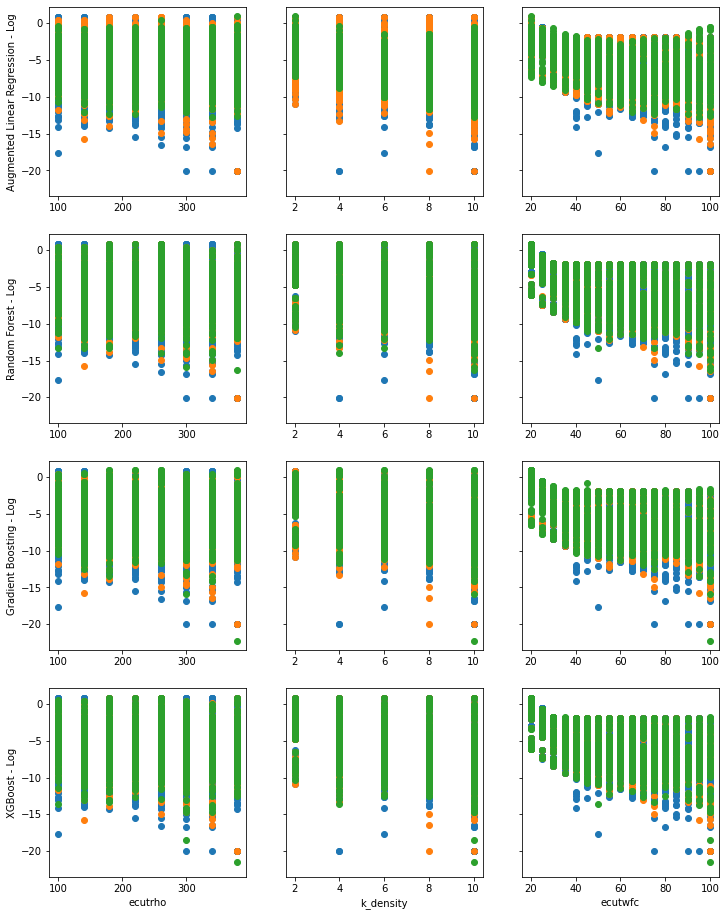

In [28]:
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], logy_train)
        ax[j,i].scatter(X_test[col], logy_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')

# Find best parameters for a given error

In [29]:
from scipy.optimize import NonlinearConstraint, LinearConstraint, minimize, shgo, differential_evolution

In [30]:
def sanitize_input(x):
    return np.array([int(round(x_i)) for x_i in x])

def delta_E_prediction(x, model, structure_encoding):
    input = np.concatenate([x, structure_encoding])
    input = pd.DataFrame(input.reshape(1, -1), columns=X_raw.columns)
    return model.predict(input)[0]

def complexity(x):
    # we have to get the right formula for the complexity
    ecutrho = x[0]
    k_density = x[1]
    ecutwfc = x[2]
    return ecutrho + k_density + ecutwfc

In [31]:
# Compute GeTe structure encoding
GeTe_encoding = np.array(pd.read_csv(os.path.join(DATA_DIR, f"Ge-1_Te-1_{encoding}.csv"), index_col=0).iloc[0, 6:].values, dtype=float)

### Minimize complexity using $\Delta E$ regressors

In [32]:
x_0 = [100, 10, 100]
max_delta_E = 1e-3
model = xgb_model
model_pred_func = lambda x: delta_E_prediction(x, model, GeTe_encoding)

nonlin_constraint = NonlinearConstraint(lambda x: delta_E_prediction(x, model), 0, max_delta_E)
# lin_constraint = LinearConstraint(A=np.eye(3), lb=np.array([1,0,1]), ub=np.array([1000,0.5,1000]))

print(model_pred_func(x_0))

mu = 1e100
pen_func = lambda x: complexity(x) + mu * max(model_pred_func(x) - max_delta_E, 0) / max_delta_E
res = differential_evolution(
    pen_func,
    bounds=[(1,1000), (1, 10), (1,1000)],
    seed=0,
)

print(res)
print(sanitize_input(res.x))

print(model_pred_func(res.x))

# codes below don't work

# minimize(complexity, x_0, constraints=[nonlin_constraint, lin_constraint])

# res = minimize(complexity, x0=x_0, bounds=[(1,1000), (1e-16,0.5), (1,1000)],
#     constraints=({'type': 'ineq', 'fun': lambda x: delta_E_prediction(x, model)},
#                  {'type': 'ineq', 'fun': lambda x: -delta_E_prediction(x, model) + max_delta_E}),
#     options={'maxiter': 1000},
# )


0.011406839
     fun: 165.6972543175907
 message: 'Optimization terminated successfully.'
    nfev: 1722
     nit: 37
 success: True
       x: array([120.07683969,   3.01072962,  42.60968501])
[120   3  43]
0.0009831786


### Minimize complexity using $log(\Delta E)$ regressors

In [33]:
max_delta_E = 1e-5
model_log = xgb_log_model
model_log_pred_func = lambda x: inv_log_transform(delta_E_prediction(x, model_log, GeTe_encoding), miny, eps)

mu = 1e100
pen_func = lambda x: complexity(x) + mu * max(model_log_pred_func(x) - max_delta_E, 0) / max_delta_E
res = differential_evolution(
    pen_func,
    bounds=[(1,1000), (1, 10), (1,1000)],
    seed=0,
)

print(res)
print(sanitize_input(res.x))

print(model_log_pred_func(res.x))

     fun: 210.8038726590816
 message: 'Optimization terminated successfully.'
    nfev: 1902
     nit: 41
 success: True
       x: array([120.06144506,   3.14593066,  87.59649694])
[120   3  88]
4.517975392559493e-06


### Compare predicted parameters to the ones in datasets

In [34]:
from sklearn.neighbors import NearestNeighbors

In [35]:
def find_neighbors(X, y, params, structure_encoding):
    # TODO define a good distance metric for params
    
    n_params = len(params)

    # get all rows with the same structure
    mask_same_struct = (X.values[:,n_params:] == structure_encoding).all(axis=1)
    df_same_struct = X.iloc[mask_same_struct,:n_params]
    y_same_struct = y[mask_same_struct]

    # noramlize the dataset in order to put the same importance to all parameters
    min_df, max_df = df_same_struct.min(), df_same_struct.max()
    df_same_struct = (df_same_struct - min_df) / (max_df - min_df)
    params = (params - min_df) / (max_df - min_df)

    knn = NearestNeighbors(n_neighbors=10, algorithm='auto')
    knn.fit(df_same_struct)
    dist, idx = knn.kneighbors([params], 10)
    list_dist_delta_E = [*zip(dist[0], list(y_same_struct.iloc[idx[0]]))]
    return pd.DataFrame(list_dist_delta_E, columns=["dist", "delta_E"])

In [36]:
find_neighbors(X_raw, y_raw, sanitize_input(res.x), GeTe_encoding)

,dist,delta_E
0,0.146777,0.000004
1,0.146777,0.148122
2,0.150212,0.148218
3,0.150212,0.000089
4,0.150212,0.132527
5,0.183816,0.148251
6,0.183816,0.000124
7,0.183816,0.013121
8,0.183816,0.132661
9,0.234983,0.132704
